# Grab-Microsoft Challenge 
## Traffic Management

- geohash6: geohash is a public domain geocoding system which encodes a geographic location into a short string of letters and digits with arbitrary precision. You are free to use any geohash library to encode/decode the geohashes into latitude and longitude or vice versa.(Examples:https://github.com/hkwi/python-geohash)
- day: the value indicates the sequential order and not a particular day of the month
- timestamp: start time of 15-minute intervals in the following format: <hour>:<minute>, where hour ranges from 0 to 23 and minute is either one of (0, 15, 30, 45)
- demand: aggregated demand normalised to be in the range [0,1]
    
## Problem Statements:
- Which areas have high / low traffic demand?
- How does regional traffic demand change according to day / time?
- Forecast the travel demand for next 15min / 1hour and predict areas with high travel demand

### This is train LSTM model 

#### Import python library

In [14]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt

# plot matplotlib graph
%matplotlib inline

#Import models from scikit learn module:
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, LSTM, BatchNormalization
from tensorflow.keras.layers import Dropout,Conv1D, MaxPooling1D,Activation
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split

import h5py
import sklearn.metrics as metrics
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model 

import pickle
import joblib


In [2]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"]="0"

### Define Variables

In [3]:
seed = 7
np.random.seed(seed)
modelname   = 'CNN-LSTM2-3in3out_sorted_reshuffled'
batch_size  = 8192
no_of_epoch = 20
no_of_train = 0.8

# choose a number of time steps
n_steps_in, predict_next_no_of_output = 3, 3

### Define Function

In [63]:
def createModel(): 
    inputs  = Input(shape=(X_train.shape[1],X_train.shape[2]))
    y = Bidirectional(LSTM(units=64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(inputs)
    y = BatchNormalization()(y)
    y = Bidirectional(LSTM(units=128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))(y)
    y = BatchNormalization()(y)
    y = Bidirectional(LSTM(units=128, return_sequences=True, dropout=0.4, recurrent_dropout=0.4))(y)
    y = BatchNormalization()(y)
    y = Bidirectional(LSTM(units=64, dropout=0.5, recurrent_dropout=0.5))(y)
    y = BatchNormalization()(y)
    y = Dense(predict_next_no_of_output, activation='sigmoid')(y)
  
    model = Model(inputs=inputs,outputs=y)
    model.compile(loss='mse',optimizer='adam', metrics=['mse', 'mae'])
    return model

def create_CNN_LSTM_Model(): 
  inputs  = Input(shape=(X_train.shape[1],X_train.shape[2]))
  y = Conv1D(64, 2, activation='relu')(inputs)
  y = Dropout(0.25)(y)
  y = Conv1D(48, 2, activation='relu')(y)
  y = Dropout(0.25)(y)
  y = MaxPooling1D(1)(y)
  y = Conv1D(32, 1, activation='relu')(y)
  y = Dropout(0.25)(y)
  y = MaxPooling1D(1)(y)
  y = Conv1D(32, 1, activation='relu')(y)
  y = Dropout(0.5)(y)
  y = Conv1D(16, 1, activation='relu')(y)
  y = Dropout(0.5)(y)
  y = LSTM(64, return_sequences=True, dropout=0.5, recurrent_dropout=0.5)(y)
  y = LSTM(64, return_sequences=True, dropout=0.5, recurrent_dropout=0.5)(y)
  y = LSTM(48, return_sequences=True, dropout=0.5, recurrent_dropout=0.5)(y)
  y = LSTM(32, return_sequences=True, dropout=0.5,recurrent_dropout=0.5)(y)
  y = LSTM(16, return_sequences=True, dropout=0.5,recurrent_dropout=0.5)(y)
  y = LSTM(2)(y)
  y = Dense(predict_next_no_of_output, activation='sigmoid')(y)
  
  model = Model(inputs=inputs,outputs=y)
  model.compile(loss='mse',optimizer='adam', metrics=['mse', 'mae'])
  return model

def create_CNN_LSTM_Model1(): 
  inputs  = Input(shape=(X_train.shape[1],X_train.shape[2]))
  y = Conv1D(filters=64, kernel_size=3,padding='same',kernel_regularizer=regularizers.l2(0.001))(inputs)
  y = Activation('relu')(y)
  y = Dropout(0.2)(y)
  y = BatchNormalization()(y)

  y = Conv1D(filters=128, kernel_size=3,padding='same',kernel_regularizer=regularizers.l2(0.001))(y)
  y = Activation('relu')(y)
  y = Dropout(0.3)(y)
  y = MaxPooling1D(2)(y)
  y = BatchNormalization()(y)

  y = Conv1D(filters=256, kernel_size=2,padding='same',kernel_regularizer=regularizers.l2(0.001))(y)
  y = Activation('relu')(y)
  y = Dropout(0.4)(y)
  y = BatchNormalization()(y)

  y = Conv1D(filters=128, kernel_size=2,padding='same',kernel_regularizer=regularizers.l2(0.001))(y)
  y = Activation('relu')(y)
  y = Dropout(0.5)(y)
  y = BatchNormalization()(y)

  y = LSTM(64, return_sequences=True, dropout=0.5, recurrent_dropout=0.5)(y)
  y = LSTM(32, return_sequences=True, dropout=0.5,recurrent_dropout=0.5)(y)
  y = LSTM(16, return_sequences=True, dropout=0.5,recurrent_dropout=0.5)(y)
  y = LSTM(4)(y)
    
  y = Dense(predict_next_no_of_output, activation='sigmoid')(y)
  
  model = Model(inputs=inputs,outputs=y)
  model.compile(loss='mse',optimizer='adam', metrics=['mse', 'mae'])
  return model

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

#### Reading from Preprocessed

In [5]:
xls  = pd.ExcelFile('data/Dataset_feature_sorted.xlsx')
data = pd.read_excel(xls, 'TrafficMgmt')

In [6]:
predictor_var  = ['day', 'hour', 'min', 'lat', 'long']
outcome_var    = 'demand'
no_of_features = len(predictor_var)

#### Prepare training & test data
- Since this is a time series dataset, we can try using LSTM 

In [7]:
dataset = data.to_numpy()

In [8]:
# covert into input/output
X, y = split_sequences(dataset, n_steps_in, predict_next_no_of_output)
print(X.shape, y.shape)

(1048571, 3, 5) (1048571, 3)


#### Train-test-val dataset split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42,shuffle=True)

In [10]:
print(X_train.shape, y_train.shape,X_test.shape, y_test.shape,X_val.shape, y_val.shape)

(671084, 3, 5) (671084, 3) (209715, 3, 5) (209715, 3) (167772, 3, 5) (167772, 3)


<h2><center>Create Model and test</center><h2>

<h3>LSTM<h3>

In [64]:
#model = createModel()
model = create_CNN_LSTM_Model1()
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 3, 5)]            0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 3, 64)             1024      
_________________________________________________________________
activation_4 (Activation)    (None, 3, 64)             0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 3, 64)             0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 3, 64)             256       
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 3, 128)            24704     
_________________________________________________________________
activation_5 (Activation)    (None, 3, 128)            0   

In [65]:
model.compile(loss='mse',optimizer='adam', metrics=['mse', 'mae'])

In [66]:
# Create checkpoints to save model during training and save training data into csv
# ‘monitor’ can be ‘val_acc’ or ‘val_loss’
# When set to ‘val_acc’, ‘mode’ must be ‘max’; when set to ‘val_loss’, ‘mode’ must be ‘min’

filepath       = modelname + ".hdf5"
checkpoint     = ModelCheckpoint(filepath, monitor='val_loss',verbose=0,save_best_only=True,mode='min') 
csv_logger     = CSVLogger(modelname + '.csv')
callbacks_list = [checkpoint,csv_logger]

In [67]:
# The line for training
history = model.fit(X_train, 
                     y_train, 
                     validation_data=(X_val, y_val), 
                     epochs=no_of_epoch, 
                     batch_size=batch_size,
                     shuffle=True,
                     callbacks=callbacks_list) 

Train on 671084 samples, validate on 167772 samples
Epoch 1/20
671084/671084 [==============================] - 13s 19us/sample - loss: 0.2980 - mse: 0.1600 - mae: 0.3861 - val_loss: 0.1239 - val_mse: 0.1098 - val_mae: 0.3127
Epoch 2/20
671084/671084 [==============================] - 3s 4us/sample - loss: 0.0859 - mse: 0.0823 - mae: 0.2643 - val_loss: 0.0630 - val_mse: 0.0626 - val_mae: 0.2257
Epoch 3/20
671084/671084 [==============================] - 3s 4us/sample - loss: 0.0539 - mse: 0.0538 - mae: 0.2050 - val_loss: 0.0463 - val_mse: 0.0462 - val_mae: 0.1861
Epoch 4/20
671084/671084 [==============================] - 3s 4us/sample - loss: 0.0418 - mse: 0.0418 - mae: 0.1736 - val_loss: 0.0379 - val_mse: 0.0378 - val_mae: 0.1618
Epoch 5/20
671084/671084 [==============================] - 3s 4us/sample - loss: 0.0354 - mse: 0.0354 - mae: 0.1535 - val_loss: 0.0332 - val_mse: 0.0332 - val_mae: 0.1457
Epoch 6/20
671084/671084 [==============================] - 3s 4us/sample - loss: 0.03

### Test dataset test result

In [68]:
predicted_value = model.predict(X_test)
print(mean_squared_error(y_test,predicted_value))

0.02535082225292452


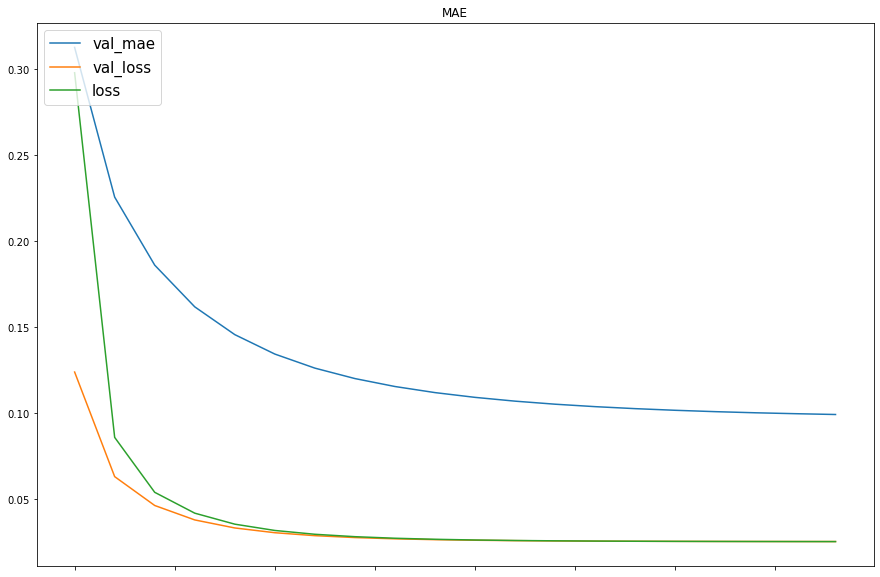

In [69]:
records     = pd.read_csv(modelname +'.csv')
plt.figure(figsize=(15,10))

ax          = plt.gca()
ax.set_xticklabels([])

plt.plot(records['val_mae'],label="val_mae")
plt.plot(records['val_loss'],label="val_loss")
plt.plot(records['loss'],label="loss")
plt.title('MAE',fontsize=12)
plt.legend(loc="upper left",fontsize=15)

plt.show()



### Load save LSTM model

In [70]:
# Load your own trained model
model = load_model(filepath, compile = False)

### Sample Testing 

In [71]:
scaler_filename = "grab_msft_sorted_scaler.save"
scaler          = joblib.load(scaler_filename) 

#### First set of testdata

In [72]:
xls  = pd.ExcelFile('data/test_sample_sorted_8000.xlsx')
test_sample = pd.read_excel(xls, 'TrafficMgmt')

# Apply Standardscalar to sample test data
test_sample[predictor_var] = scaler.fit_transform(test_sample[predictor_var])

In [73]:
# convert into input/output
test_sample_array = test_sample.to_numpy()
X_sample, y_sample = split_sequences(test_sample_array, n_steps_in, predict_next_no_of_output)
print(X_sample.shape, y_sample.shape)

(17, 3, 5) (17, 3)


In [74]:
predicted_value = model.predict(X_sample)
print('Predicted value : {} \n Actual Value    : {}' .format(predicted_value,y_sample))

Predicted value : [[0.11462059 0.10755018 0.10567734]
 [0.11462059 0.10755018 0.10567734]
 [0.11462059 0.10755018 0.10567734]
 [0.11462059 0.10755018 0.10567734]
 [0.11462059 0.10755018 0.10567734]
 [0.11462059 0.10755018 0.10567734]
 [0.11462059 0.10755018 0.10567734]
 [0.11462059 0.10755018 0.10567734]
 [0.11462059 0.10755018 0.10567734]
 [0.11462059 0.10755018 0.10567734]
 [0.11462059 0.10755018 0.10567734]
 [0.11462059 0.10755018 0.10567734]
 [0.11462059 0.10755018 0.10567734]
 [0.11462059 0.10755018 0.10567734]
 [0.11462059 0.10755018 0.10567734]
 [0.11462059 0.10755018 0.10567734]
 [0.11462059 0.10755018 0.10567734]] 
 Actual Value    : [[0.01799946 0.0531276  0.10812558]
 [0.0531276  0.10812558 0.03172353]
 [0.10812558 0.03172353 0.08252318]
 [0.03172353 0.08252318 0.64191406]
 [0.08252318 0.64191406 0.13738873]
 [0.64191406 0.13738873 0.20788158]
 [0.13738873 0.20788158 0.23219486]
 [0.20788158 0.23219486 0.00794347]
 [0.23219486 0.00794347 0.00706648]
 [0.00794347 0.00706648 0

In [75]:
print(mean_squared_error(y_sample,predicted_value))

0.05796491358266374


### single sample test

In [76]:
# Data input sequence format :
test_data1  = [[0.14285714, 0.43478261, 0.66666667, 0.97435897,0.92307692],
               [0.40816327, 0.04347826, 0.33333333, 0.76923077,0.46153846],
               [0.06122449, 0.91304348, 0.66666667, 0.35897436,0.65384615]]
test_data2  = [[0.40816327, 0.04347826, 0.33333333, 0.76923077,0.46153846],
               [0.06122449, 0.91304348, 0.66666667, 0.35897436,0.65384615],
               [0.97959184, 0.30434783, 0.33333333, 0.        ,0.07692308]]
test_data3  = [[0.06122449, 0.91304348, 0.66666667, 0.35897436,0.65384615],
               [0.97959184, 0.30434783, 0.33333333, 0.        ,0.07692308],
               [0.6122449 , 0.34782609, 0.33333333, 0.46153846,0.23076923]]
test_data4  = [[0.97959184, 0.30434783, 0.33333333, 0.        ,0.07692308],
               [0.6122449 , 0.34782609, 0.33333333, 0.46153846,0.23076923],
               [0.6122449 , 0.13043478, 0.        , 0.46153846,0.5       ]]
test_data5  = [[0.6122449 , 0.34782609, 0.33333333, 0.46153846,0.23076923],
               [0.6122449 , 0.13043478, 0.        , 0.46153846,0.5       ],
               [0.71428571, 0.95652174, 0.66666667, 0.92307692,0.80769231]]
test_data6  = [[0.6122449 , 0.13043478, 0.        , 0.46153846,0.5       ],
               [0.71428571, 0.95652174, 0.66666667, 0.92307692,0.80769231],
               [0.2244898 , 0.30434783, 0.        , 0.12820513,0.15384615]]
test_data7  = [[0.71428571, 0.95652174, 0.66666667, 0.92307692,0.80769231],
               [0.2244898 , 0.30434783, 0.        , 0.12820513,0.15384615],
               [0.34693878, 0.30434783, 0.        , 0.79487179,1.        ]]
test_data8  = [[0.2244898 , 0.30434783, 0.        , 0.12820513,0.15384615],
               [0.34693878, 0.30434783, 0.        , 0.79487179,1.        ],
               [0.32653061, 0.08695652, 0.        , 0.82051282,1.        ]]
test_data9  = [[0.34693878, 0.30434783, 0.        , 0.79487179,1.        ],
               [0.32653061, 0.08695652, 0.        , 0.82051282,1.        ],
               [0.73469388, 0.30434783, 1.        , 0.28205128,0.73076923]]
test_data10 = [[0.32653061, 0.08695652, 0.        , 0.82051282,1.        ],
               [0.73469388, 0.30434783, 1.        , 0.28205128,0.73076923],
               [0.6122449 , 0.        , 0.        , 0.28205128,0.        ]]

test_data1  = np.expand_dims(test_data1, axis=0)
test_data2  = np.expand_dims(test_data2, axis=0)
test_data3  = np.expand_dims(test_data3, axis=0)
test_data4  = np.expand_dims(test_data4, axis=0)
test_data5  = np.expand_dims(test_data5, axis=0)
test_data6  = np.expand_dims(test_data6, axis=0)
test_data7  = np.expand_dims(test_data7, axis=0)
test_data8  = np.expand_dims(test_data8, axis=0)
test_data9  = np.expand_dims(test_data9, axis=0)
test_data10 = np.expand_dims(test_data10, axis=0)

test_target1  = [0.04113812, 0.06282991, 0.15961478]
test_target2  = [0.06282991, 0.15961478, 0.90994164]
test_target3  = [0.15961478, 0.90994163, 0.00090106]
test_target4  = [0.90994163, 0.00090106, 0.13262154]
test_target5  = [0.00090106, 0.13262155, 0.19313787]
test_target6  = [0.13262155, 0.19313787, 0.04086969]
test_target7  = [0.19313787, 0.04086969, 0.02042785]
test_target8  = [0.04086969, 0.02042785, 0.06948841]
test_target9  = [0.02042785, 0.06948841, 0.04174341]
test_target10 = [0.06948841, 0.04174341, 0.19069707]

In [77]:
predicted_value = model.predict(test_data1)
print('Predicted value : {}\nActual Value    : {}' .format(predicted_value,test_target1))

Predicted value : [[0.11462059 0.10755018 0.10567734]]
Actual Value    : [0.04113812, 0.06282991, 0.15961478]


In [78]:
predicted_value = model.predict(test_data2)
print('Predicted value : {}\nActual Value    : {}' .format(predicted_value,test_target2))

Predicted value : [[0.11462059 0.10755018 0.10567734]]
Actual Value    : [0.06282991, 0.15961478, 0.90994164]


In [79]:
predicted_value = model.predict(test_data3)
print('Predicted value : {}\nActual Value    : {}' .format(predicted_value,test_target3))

Predicted value : [[0.11462059 0.10755018 0.10567734]]
Actual Value    : [0.15961478, 0.90994163, 0.00090106]


In [80]:
predicted_value = model.predict(test_data4)
print('Predicted value : {}\nActual Value    : {}' .format(predicted_value,test_target4))

Predicted value : [[0.11462059 0.10755018 0.10567734]]
Actual Value    : [0.90994163, 0.00090106, 0.13262154]


In [81]:
predicted_value = model.predict(test_data5)
print('Predicted value : {}\nActual Value    : {}' .format(predicted_value,test_target5))

Predicted value : [[0.11462059 0.10755018 0.10567734]]
Actual Value    : [0.00090106, 0.13262155, 0.19313787]


In [82]:
predicted_value = model.predict(test_data6)
print('Predicted value : {}\nActual Value    : {}' .format(predicted_value,test_target6))

Predicted value : [[0.11462059 0.10755018 0.10567734]]
Actual Value    : [0.13262155, 0.19313787, 0.04086969]


In [83]:
predicted_value = model.predict(test_data7)
print('Predicted value : {}\nActual Value    : {}' .format(predicted_value,test_target7))

Predicted value : [[0.11462059 0.10755018 0.10567734]]
Actual Value    : [0.19313787, 0.04086969, 0.02042785]


In [84]:
predicted_value = model.predict(test_data8)
print('Predicted value : {}\nActual Value    : {}' .format(predicted_value,test_target8))

Predicted value : [[0.11462059 0.10755018 0.10567734]]
Actual Value    : [0.04086969, 0.02042785, 0.06948841]


In [85]:
predicted_value = model.predict(test_data9)
print('Predicted value : {}\nActual Value    : {}' .format(predicted_value,test_target9))

Predicted value : [[0.11462059 0.10755018 0.10567734]]
Actual Value    : [0.02042785, 0.06948841, 0.04174341]


In [86]:
predicted_value = model.predict(test_data10)
print('Predicted value : {}\nActual Value    : {}' .format(predicted_value,test_target10))

Predicted value : [[0.11462059 0.10755018 0.10567734]]
Actual Value    : [0.06948841, 0.04174341, 0.19069707]
